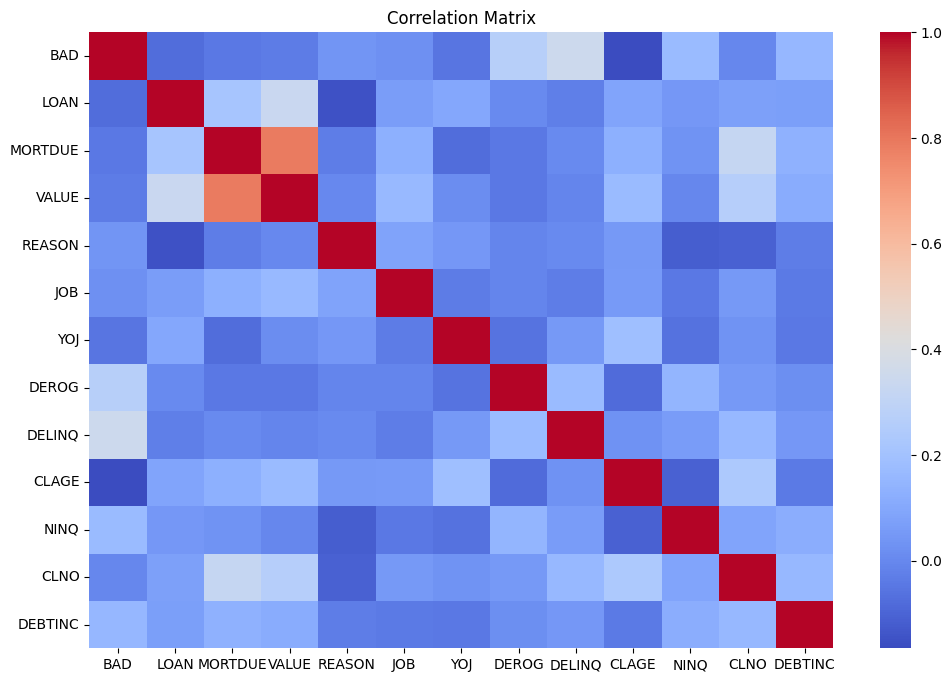

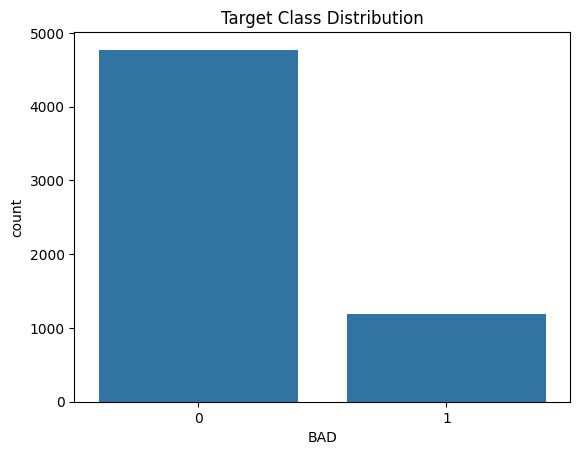

[LightGBM] [Info] Number of positive: 832, number of negative: 3340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1441
[LightGBM] [Info] Number of data points in the train set: 4172, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199425 -> initscore=-1.389894
[LightGBM] [Info] Start training from score -1.389894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

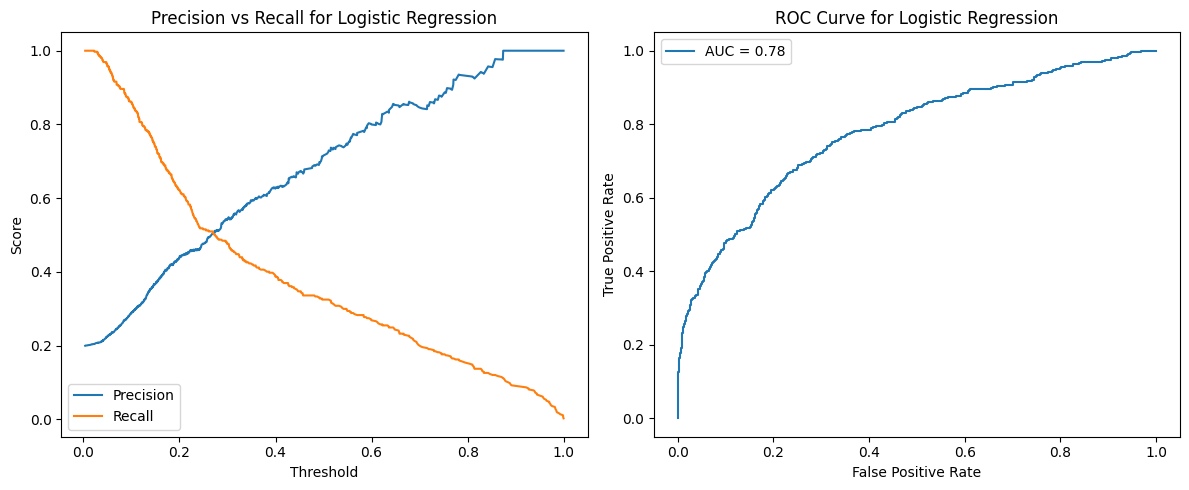

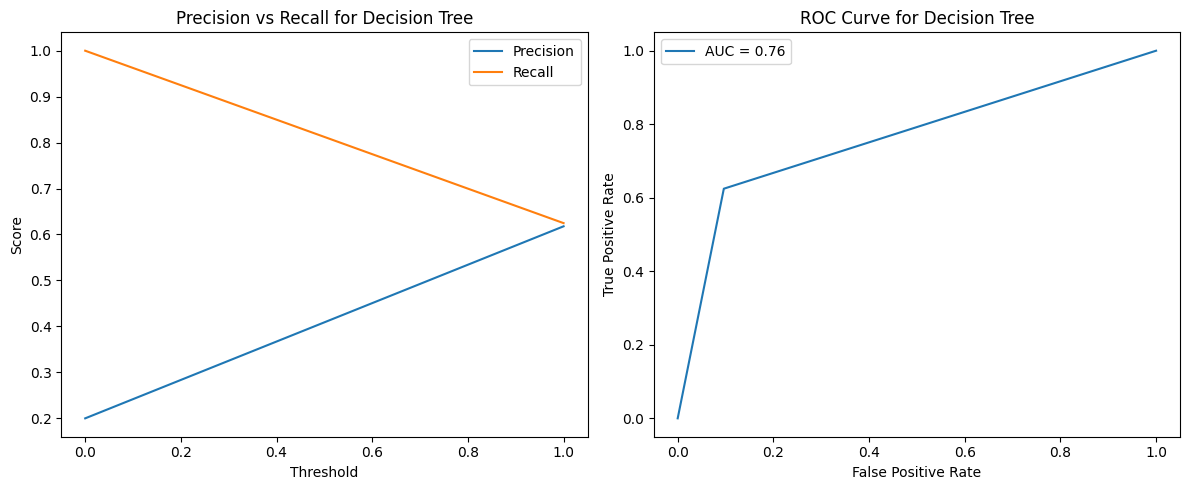

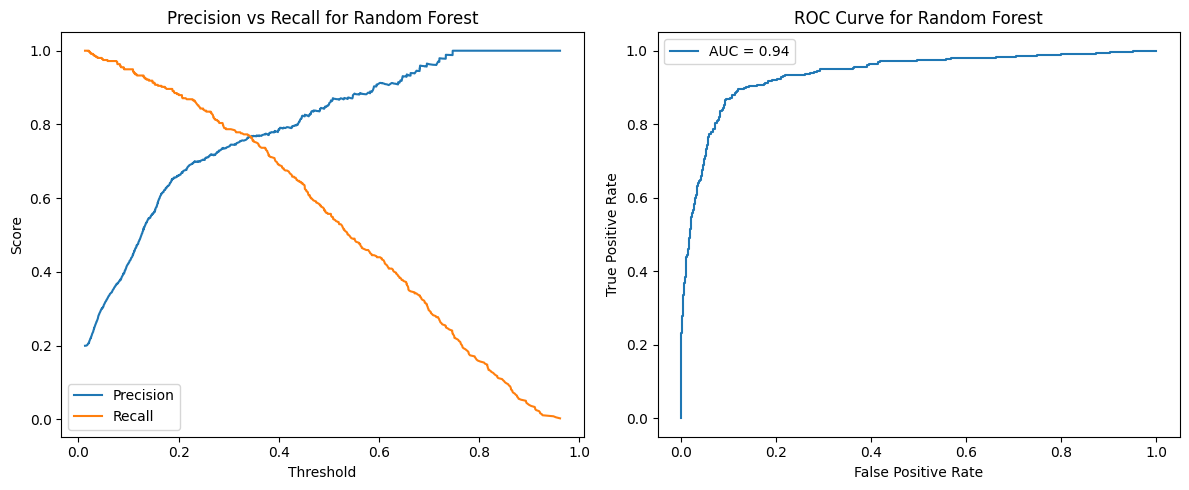

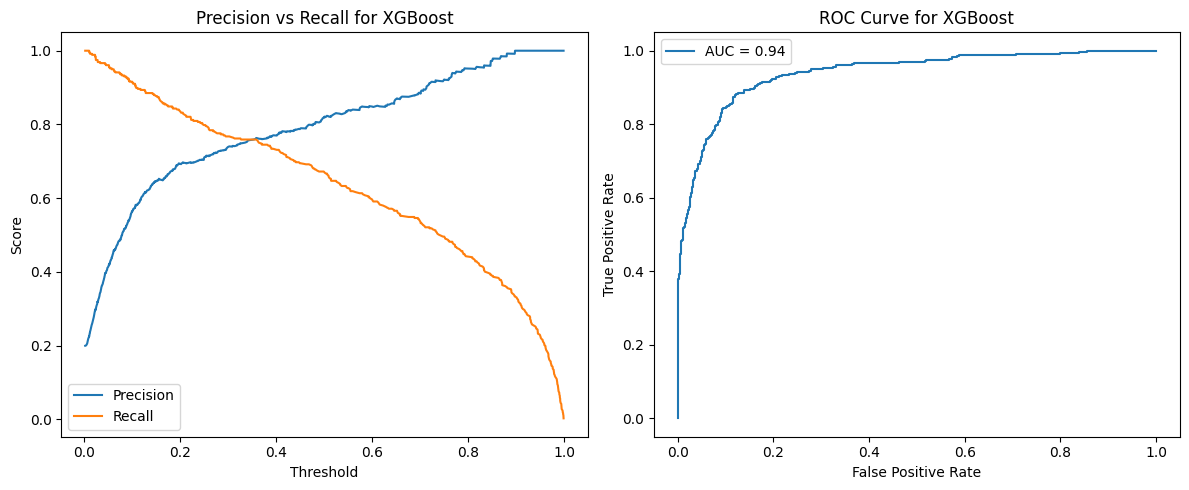

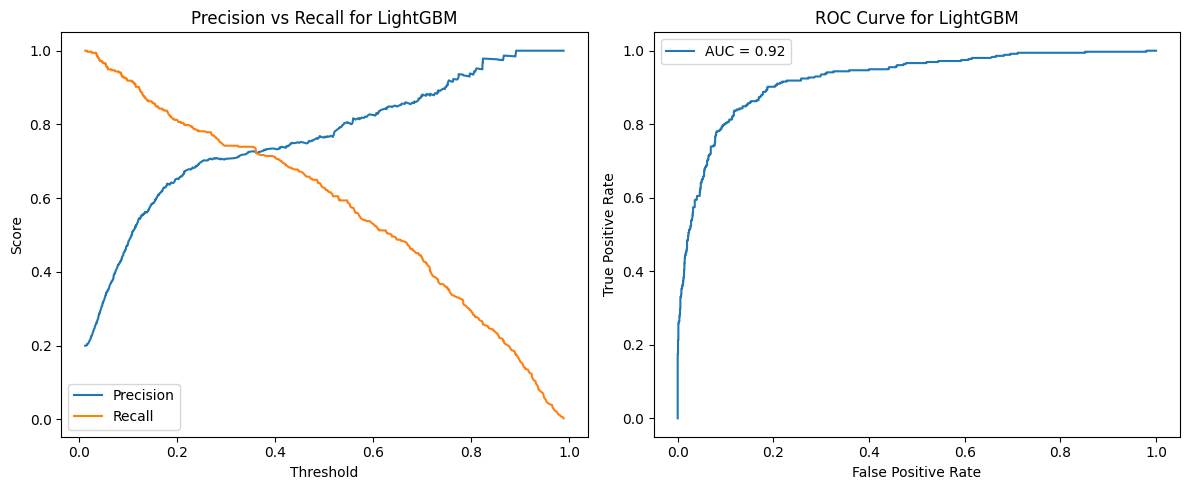

Tuned Decision Tree:
Best Params: {'max_depth': 5, 'min_samples_split': 2}
Recall: 0.6610644257703081
Precision: 0.7173252279635258
AUC: 0.7980374539753008


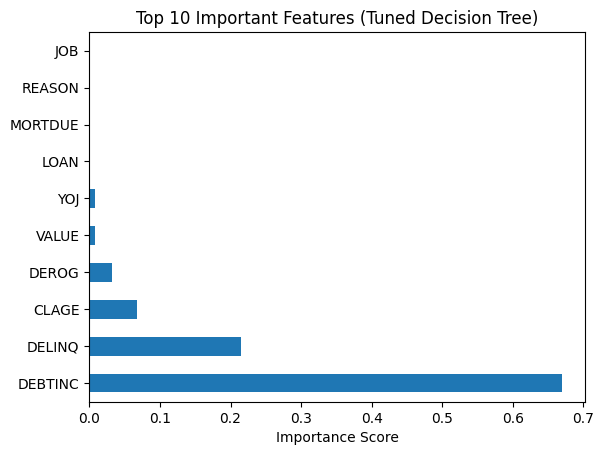

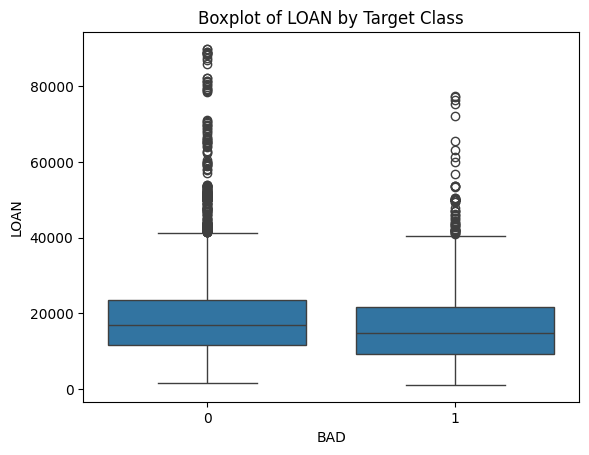

In [4]:
# Loan Default Prediction with Enhanced Visuals and Threshold Optimization

# STEP 1: Install required libraries
!pip install xgboost lightgbm shap --quiet

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

# STEP 3: Load dataset
df = pd.read_csv("/content/hmeq.csv")  # Upload this file to Colab manually


# STEP 4: Handle missing values
df = df.dropna(subset=['BAD'])
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('BAD')
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# STEP 5: Visualizations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

sns.countplot(x='BAD', data=df)
plt.title("Target Class Distribution")
plt.show()

# STEP 6: Feature and target split + Scaling
X = df.drop('BAD', axis=1)
y = df['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# STEP 7: Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=4, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=4)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {
        "model": model,
        "accuracy": report["accuracy"],
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1": report["1"]["f1-score"],
        "roc_auc": auc,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

# STEP 8: Summary Table
summary = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"])
for name, res in results.items():
    summary.loc[len(summary)] = [
        name,
        res["accuracy"],
        res["precision"],
        res["recall"],
        res["f1"],
        res["roc_auc"]
    ]
print(summary)

# STEP 9: Threshold Optimization & ROC/PR Curves
for name, res in results.items():
    y_proba = res["y_proba"]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision vs Recall for {name}')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(fpr, tpr, label=f'AUC = {res["roc_auc"]:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# STEP 10: GridSearchCV for Decision Tree
params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='recall')
gs.fit(X_train, y_train)
y_pred_tuned = gs.predict(X_test)

print("Tuned Decision Tree:")
print("Best Params:", gs.best_params_)
print("Recall:", recall_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("AUC:", roc_auc_score(y_test, y_pred_tuned))

# STEP 11: Feature Importance
feature_importance = pd.Series(gs.best_estimator_.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features (Tuned Decision Tree)")
plt.xlabel("Importance Score")
plt.show()

# STEP 12: Boxplot
example_feature = X.columns[0]
sns.boxplot(x=y, y=df[example_feature])
plt.title(f"Boxplot of {example_feature} by Target Class")
plt.show()


In [5]:
# Add to your notebook (after predictions)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['Actual'] = y_test.values
X_test_df['Predicted'] = results["XGBoost"]["y_pred"]
false_negatives = X_test_df[(X_test_df['Actual'] == 1) & (X_test_df['Predicted'] == 0)]
false_positives = X_test_df[(X_test_df['Actual'] == 0) & (X_test_df['Predicted'] == 1)]

print("Sample False Negatives:")
print(false_negatives.head())

print("Sample False Positives:")
print(false_positives.head())


Sample False Negatives:
        LOAN   MORTDUE     VALUE    REASON       JOB       YOJ     DEROG  \
0  -0.652415  0.957345  0.649517 -0.663034 -1.738969 -0.513522 -0.280555   
9  -0.822072 -0.821688 -0.724607 -0.663034  0.062168  0.709181 -0.280555   
24 -0.866719 -0.932343 -0.889348 -0.663034 -0.838401 -0.921089 -0.280555   
34  1.026300 -0.190956 -0.907802  1.508219 -0.838401 -0.649377 -0.280555   
54 -0.947083  1.260216  1.127293  1.508219 -1.738969  0.165757 -0.280555   

      DELINQ     CLAGE      NINQ      CLNO   DEBTINC  Actual  Predicted  
0  -0.372823  0.414149 -0.107506  1.475783  0.111652       1          0  
9  -0.372823 -1.038793 -0.712792 -0.317189 -0.594693       1          0  
24 -0.372823 -1.171506 -0.107506 -0.117970 -2.331801       1          0  
34  0.529915 -0.719450 -0.107506 -0.616018  0.111652       1          0  
54 -0.372823 -0.064853 -0.107506 -0.117970  0.111652       1          0  
Sample False Positives:
         LOAN   MORTDUE     VALUE    REASON       J

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load the dataset
df = pd.read_csv("/content/hmeq.csv")  # Make sure this is uploaded in Colab

# Separate numeric and non-numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

# Impute numeric columns with median
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Impute categorical columns with most frequent
imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Split into features and target
X = df.drop("BAD", axis=1)
y = df["BAD"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "XGBoost (default)": XGBClassifier(n_estimators=50, max_depth=4, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=4, random_state=42)
}

results = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results.append({
        "Model": name,
        "False Negatives": fn,
        "False Positives": fp
    })

# XGBoost with threshold = 0.3
xgb = XGBClassifier(n_estimators=50, max_depth=4, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
y_probs = xgb.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= 0.3).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
results.append({
    "Model": "XGBoost (threshold = 0.3)",
    "False Negatives": fn,
    "False Positives": fp
})

# Show result table
results_df = pd.DataFrame(results)
print("False Negatives and False Positives Table")
display(results_df)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:50:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 832, number of negative: 3340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 4172, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199425 -> initscore=-1.389894
[LightGBM] [Info] Start training from score -1.389894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:50:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


False Negatives and False Positives Table


,Model,False Negatives,False Positives
0,Logistic Regression,239,49
1,Decision Tree,130,133
2,Random Forest,145,32
3,XGBoost (default),117,55
4,LightGBM,127,68
5,XGBoost (threshold = 0.3),77,101


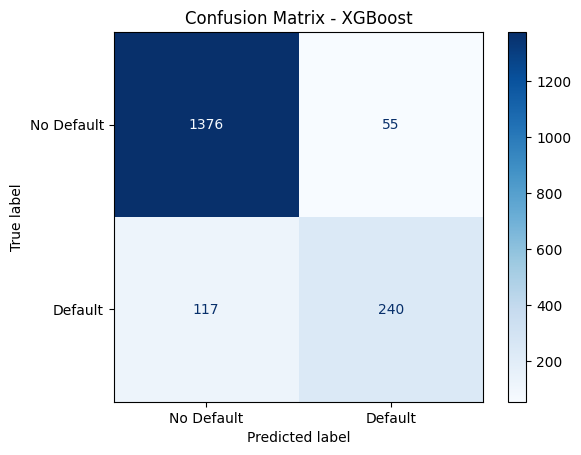

In [7]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Train XGBoost if not already
xgb_model = XGBClassifier(n_estimators=50, max_depth=4, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Step 2: Predict
y_pred_xgb = xgb_model.predict(X_test)

# Step 3: Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()